# Ames Housing Dataset

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns
import scipy
import math

from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve
from sklearn.model_selection import cross_validate

##Regressors
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

##Settings
pd.options.display.max_rows = 30
pd.options.display.max_columns = 40
pd.options.display.float_format = '{:.4f}'.format
from IPython.display import display, HTML
import warnings
warnings.filterwarnings("ignore")

In [2]:
train=pd.read_csv("train.csv")

In [3]:
test=pd.read_csv("test.csv")

In [4]:
df =  pd.concat(objs=[train, test], axis=0).reset_index(drop=True)

In [25]:
df["Id"].tail()

2914    2915
2915    2916
2916    2917
2917    2918
2918    2919
Name: Id, dtype: int64

In [6]:
train.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.0000,1460.0000,1201.0000,1460.0000,1460.0000,1460.0000,1460.0000,1460.0000,1452.0000,1460.0000,1460.0000,1460.0000,1460.0000,1460.0000,1460.0000,1460.0000,1460.0000,1460.0000,1460.0000,1460.0000,1460.0000,1460.0000,1460.0000,1460.0000,1460.0000,1379.0000,1460.0000,1460.0000,1460.0000,1460.0000,1460.0000,1460.0000,1460.0000,1460.0000,1460.0000,1460.0000,1460.0000,1460.0000
mean,730.5000,56.8973,70.0500,10516.8281,6.0993,5.5753,1971.2678,1984.8658,103.6853,443.6397,46.5493,567.2404,1057.4295,1162.6267,346.9925,5.8445,1515.4637,0.4253,0.0575,1.5651,0.3829,2.8664,1.0466,6.5178,0.6130,1978.5062,1.7671,472.9801,94.2445,46.6603,21.9541,3.4096,15.0610,2.7589,43.4890,6.3219,2007.8158,180921.1959
std,421.6100,42.3006,24.2848,9981.2649,1.3830,1.1128,30.2029,20.6454,181.0662,456.0981,161.3193,441.8670,438.7053,386.5877,436.5284,48.6231,525.4804,0.5189,0.2388,0.5509,0.5029,0.8158,0.2203,1.6254,0.6447,24.6897,0.7473,213.8048,125.3388,66.2560,61.1191,29.3173,55.7574,40.1773,496.1230,2.7036,1.3281,79442.5029
min,1.0000,20.0000,21.0000,1300.0000,1.0000,1.0000,1872.0000,1950.0000,0.0000,0.0000,0.0000,0.0000,0.0000,334.0000,0.0000,0.0000,334.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,2.0000,0.0000,1900.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,2006.0000,34900.0000
25%,365.7500,20.0000,59.0000,7553.5000,5.0000,5.0000,1954.0000,1967.0000,0.0000,0.0000,0.0000,223.0000,795.7500,882.0000,0.0000,0.0000,1129.5000,0.0000,0.0000,1.0000,0.0000,2.0000,1.0000,5.0000,0.0000,1961.0000,1.0000,334.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,5.0000,2007.0000,129975.0000
50%,730.5000,50.0000,69.0000,9478.5000,6.0000,5.0000,1973.0000,1994.0000,0.0000,383.5000,0.0000,477.5000,991.5000,1087.0000,0.0000,0.0000,1464.0000,0.0000,0.0000,2.0000,0.0000,3.0000,1.0000,6.0000,1.0000,1980.0000,2.0000,480.0000,0.0000,25.0000,0.0000,0.0000,0.0000,0.0000,0.0000,6.0000,2008.0000,163000.0000
75%,1095.2500,70.0000,80.0000,11601.5000,7.0000,6.0000,2000.0000,2004.0000,166.0000,712.2500,0.0000,808.0000,1298.2500,1391.2500,728.0000,0.0000,1776.7500,1.0000,0.0000,2.0000,1.0000,3.0000,1.0000,7.0000,1.0000,2002.0000,2.0000,576.0000,168.0000,68.0000,0.0000,0.0000,0.0000,0.0000,0.0000,8.0000,2009.0000,214000.0000
max,1460.0000,190.0000,313.0000,215245.0000,10.0000,9.0000,2010.0000,2010.0000,1600.0000,5644.0000,1474.0000,2336.0000,6110.0000,4692.0000,2065.0000,572.0000,5642.0000,3.0000,2.0000,3.0000,2.0000,8.0000,3.0000,14.0000,3.0000,2010.0000,4.0000,1418.0000,857.0000,547.0000,552.0000,508.0000,480.0000,738.0000,15500.0000,12.0000,2010.0000,755000.0000


In [7]:
train.shape

(1460, 81)

In [8]:
test.shape

(1459, 80)

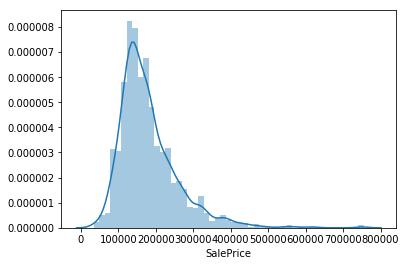

In [9]:
sns.distplot(train["SalePrice"])

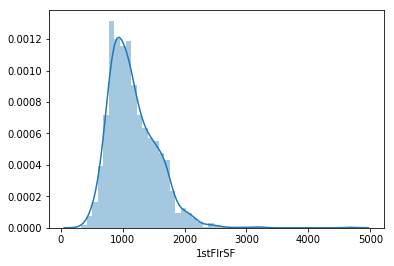

In [10]:
sns.distplot(train["1stFlrSF"])

In [11]:
train.describe(include=["O"])

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,...,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
count,1460,1460,91,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1452,1460,1460,...,1422,1423,1422,1460,1460,1460,1459,1460,1460,770,1379,1379,1379,1379,1460,7,281,54,1460,1460
unique,5,2,2,4,4,2,5,3,25,9,8,5,8,6,8,15,16,4,4,5,...,4,6,6,6,5,2,5,4,7,5,6,3,5,5,3,3,4,4,9,6
top,RL,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,Gable,CompShg,VinylSd,VinylSd,None,TA,TA,...,No,Unf,Unf,GasA,Ex,Y,SBrkr,TA,Typ,Gd,Attchd,Unf,TA,TA,Y,Gd,MnPrv,Shed,WD,Normal
freq,1151,1454,50,925,1311,1459,1052,1382,225,1260,1445,1220,726,1141,1434,515,504,864,906,1282,...,953,430,1256,1428,741,1365,1334,735,1360,380,870,605,1311,1326,1340,3,157,49,1267,1198


In [12]:
df["LSalePrice"]=np.log(train["SalePrice"])
df["LSalePrice"]=np.log(df["SalePrice"])

In [13]:
df.head()

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtFinType1,BsmtFinType2,BsmtFullBath,BsmtHalfBath,BsmtQual,BsmtUnfSF,CentralAir,Condition1,Condition2,Electrical,...,OverallCond,OverallQual,PavedDrive,PoolArea,PoolQC,RoofMatl,RoofStyle,SaleCondition,SalePrice,SaleType,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,Utilities,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold,LSalePrice
0,856,854,0,NaN,3,1Fam,TA,No,706.0000,0.0000,GLQ,Unf,1.0000,0.0000,Gd,150.0000,Y,Norm,Norm,SBrkr,...,5,7,Y,0,NaN,CompShg,Gable,Normal,208500.0000,WD,0,Pave,8,856.0000,AllPub,0,2003,2003,2008,12.2477
1,1262,0,0,NaN,3,1Fam,TA,Gd,978.0000,0.0000,ALQ,Unf,0.0000,1.0000,Gd,284.0000,Y,Feedr,Norm,SBrkr,...,8,6,Y,0,NaN,CompShg,Gable,Normal,181500.0000,WD,0,Pave,6,1262.0000,AllPub,298,1976,1976,2007,12.1090
2,920,866,0,NaN,3,1Fam,TA,Mn,486.0000,0.0000,GLQ,Unf,1.0000,0.0000,Gd,434.0000,Y,Norm,Norm,SBrkr,...,5,7,Y,0,NaN,CompShg,Gable,Normal,223500.0000,WD,0,Pave,6,920.0000,AllPub,0,2001,2002,2008,12.3172
3,961,756,0,NaN,3,1Fam,Gd,No,216.0000,0.0000,ALQ,Unf,1.0000,0.0000,TA,540.0000,Y,Norm,Norm,SBrkr,...,5,7,Y,0,NaN,CompShg,Gable,Abnorml,140000.0000,WD,0,Pave,7,756.0000,AllPub,0,1915,1970,2006,11.8494
4,1145,1053,0,NaN,4,1Fam,TA,Av,655.0000,0.0000,GLQ,Unf,1.0000,0.0000,Gd,490.0000,Y,Norm,Norm,SBrkr,...,5,8,Y,0,NaN,CompShg,Gable,Normal,250000.0000,WD,0,Pave,9,1145.0000,AllPub,192,2000,2000,2008,12.4292


In [14]:
df.shape

(2919, 82)

In [15]:
df.shape

(2919, 82)

## EDA

### Important features

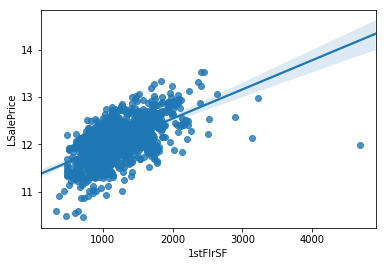

In [17]:
p=sns.regplot(x="1stFlrSF",y="LSalePrice",data=df)

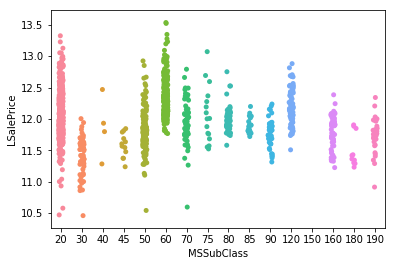

In [18]:
g=sns.stripplot(x="MSSubClass",y="LSalePrice",jitter=True,data=df)

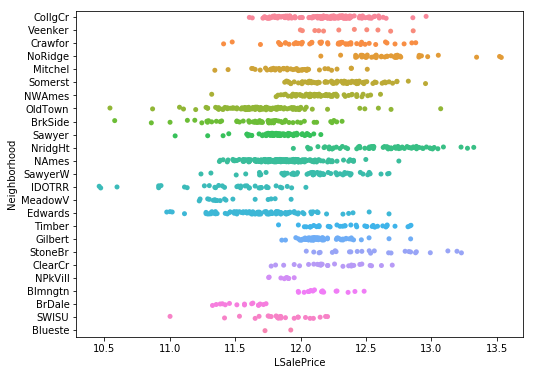

In [19]:
plt.figure(figsize=(8,6))
sns.stripplot(y="Neighborhood",x="LSalePrice",data=df,jitter=True)

### Medium important

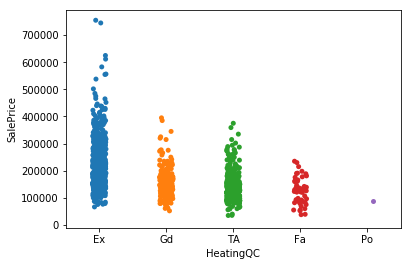

In [20]:
g=sns.stripplot(x="HeatingQC",y="SalePrice",jitter=True,data=train)

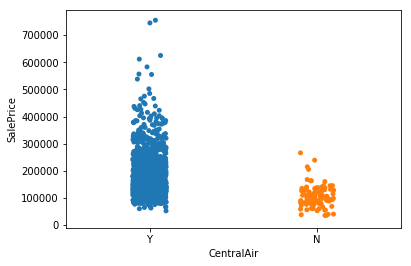

In [21]:
g=sns.stripplot(x="CentralAir",y="SalePrice",jitter=True,data=df)

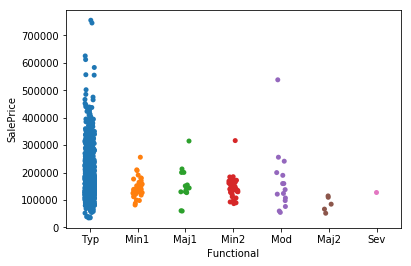

In [22]:
g=sns.stripplot(x="Functional",y="SalePrice",jitter=True,data=train)

### Low important 

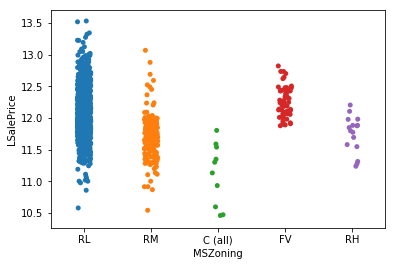

In [22]:
g=sns.stripplot(x="MSZoning",y="LSalePrice",jitter=True,data=df)

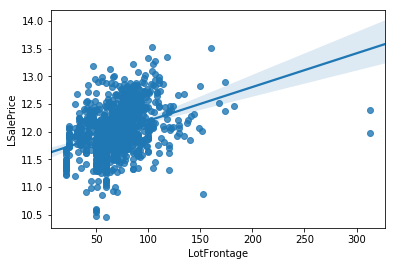

In [23]:
g=sns.regplot(x="LotFrontage",y="LSalePrice",data=df)

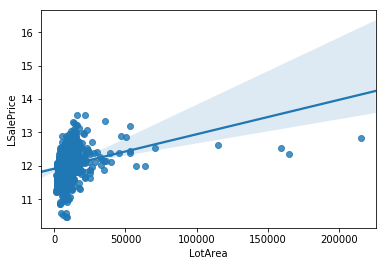

In [24]:
g=sns.regplot(x="LotArea",y="LSalePrice",data=df)

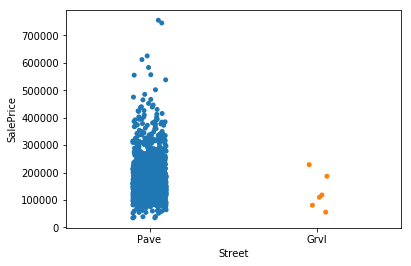

In [25]:
g=sns.stripplot(x="Street",y="SalePrice",jitter=True,data=train)

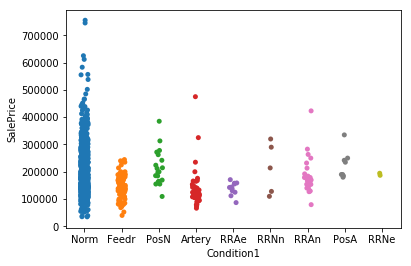

In [42]:
g=sns.stripplot(x="Condition1",y="SalePrice",jitter=True,data=train)

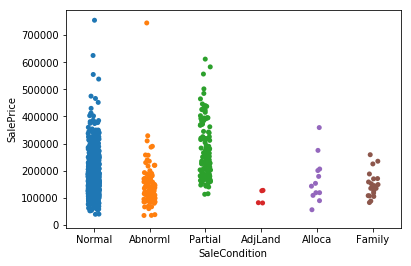

In [39]:
g=sns.stripplot(x="SaleCondition",y="SalePrice",jitter=True,data=train)

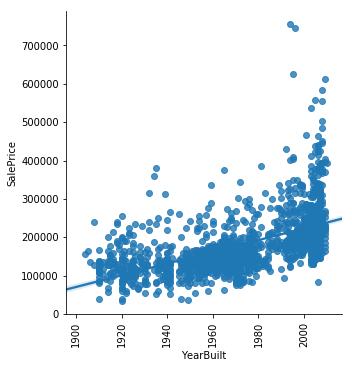

In [57]:
g=sns.lmplot(x="YearBuilt",y="SalePrice",data=df[df["YearBuilt"]>1900])
plt.xticks(rotation=90)
plt.show()

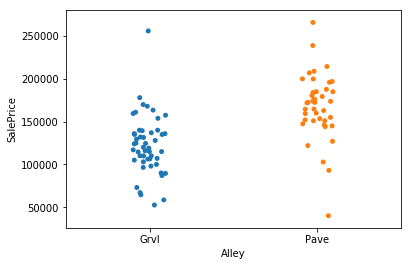

In [26]:
g=sns.stripplot(x="Alley",y="SalePrice",jitter=True,data=train)

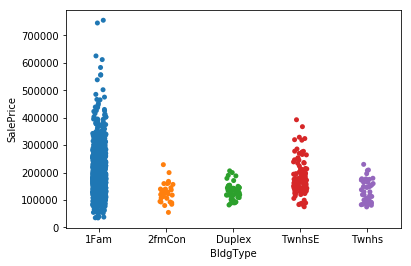

In [51]:
g=sns.stripplot(x="BldgType",y="SalePrice",jitter=True,data=train)

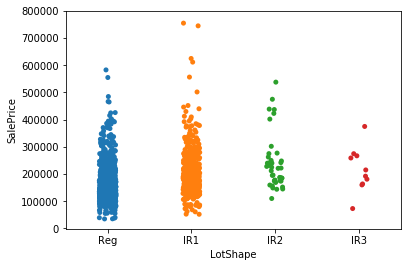

In [27]:
g=sns.stripplot(x="LotShape",y="SalePrice",jitter=True,data=train)

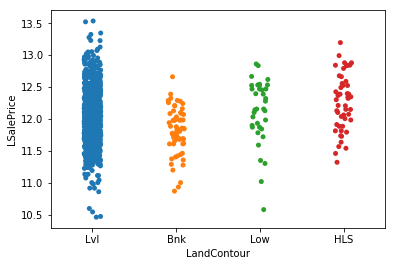

In [28]:
g=sns.stripplot(x="LandContour",y="LSalePrice",jitter=True,data=df)

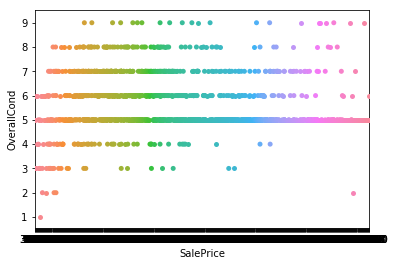

In [29]:
g=sns.stripplot(y="OverallCond",x="SalePrice",data=train,jitter=True)

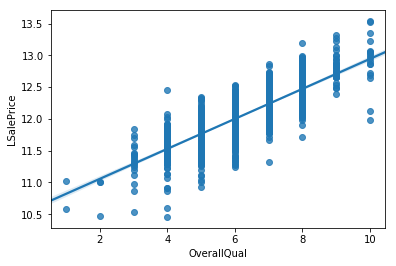

In [30]:
g=sns.regplot(x="OverallQual",y="LSalePrice",data=df)

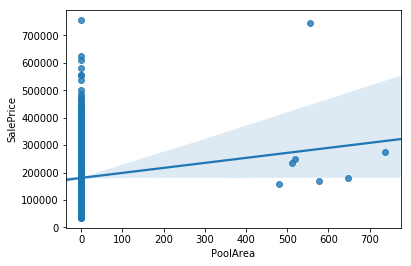

In [31]:
g=sns.regplot(x="PoolArea",y="SalePrice",data=train)

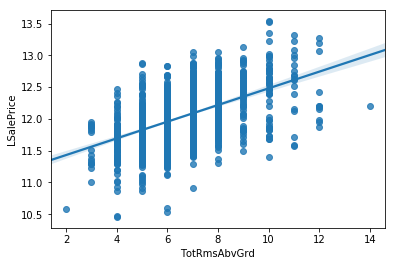

In [43]:
g=sns.regplot(x="TotRmsAbvGrd",y="LSalePrice",data=df)

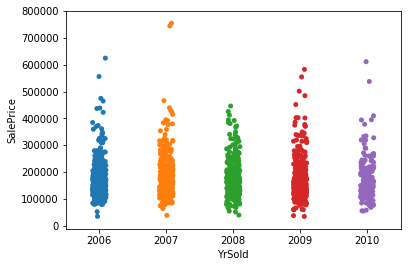

In [39]:
g=sns.stripplot(x="YrSold",y="SalePrice",jitter=True,data=train)

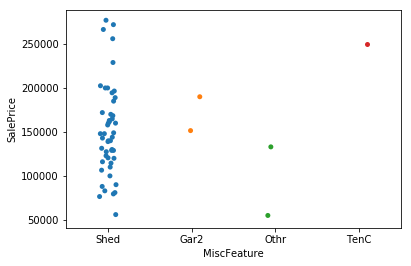

In [44]:
g=sns.stripplot(x="MiscFeature",y="SalePrice",jitter=True,data=train)

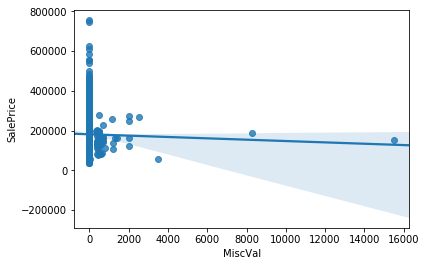

In [45]:
g=sns.regplot(x="MiscVal",y="SalePrice",data=train)

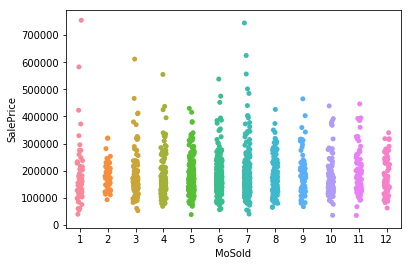

In [38]:
g=sns.stripplot(x="MoSold",y="SalePrice",jitter=True,data=train)

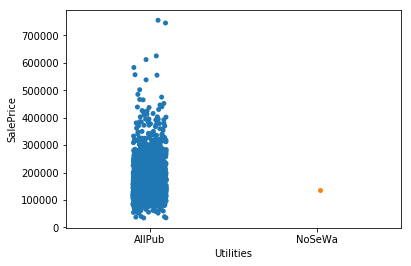

In [50]:
g=sns.stripplot(x="Utilities",y="SalePrice",jitter=True,data=train)

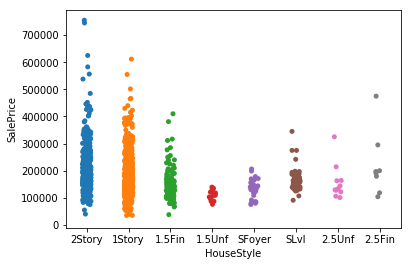

In [33]:
g=sns.stripplot(x="HouseStyle",y="SalePrice",jitter=True,data=train)

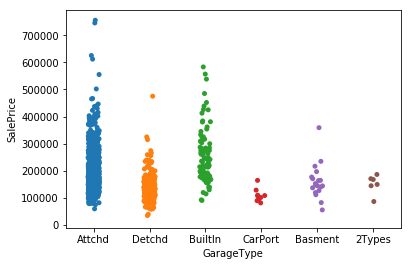

In [36]:
g=sns.stripplot(x="GarageType",y="SalePrice",jitter=True,data=train)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 <a list of 15 Text xticklabel objects>)

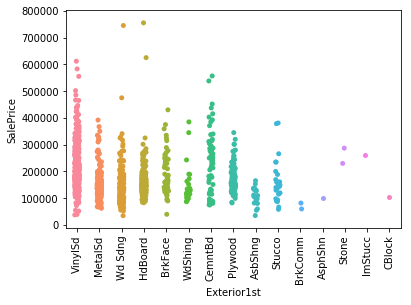

In [40]:
g=sns.stripplot(x="Exterior1st",y="SalePrice",jitter=True,data=train)
plt.xticks(rotation=90)
plt.show()

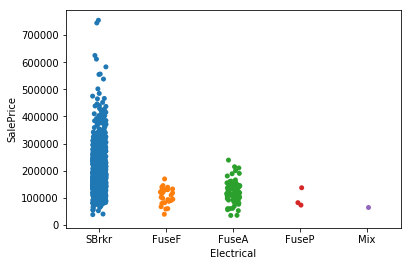

In [47]:
g=sns.stripplot(x="Electrical",y="SalePrice",jitter=True,data=train)

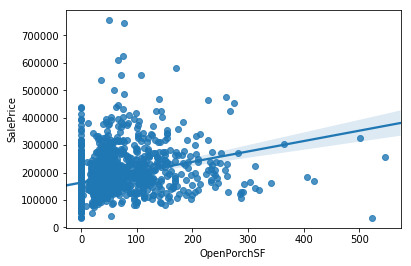

In [46]:
g=sns.regplot(x="OpenPorchSF",y="SalePrice",data=train)

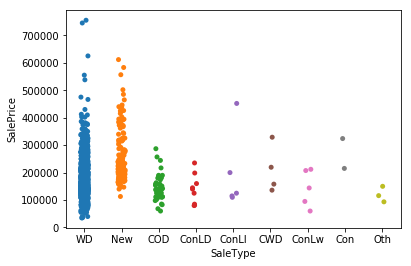

In [40]:
g=sns.stripplot(x="SaleType",y="SalePrice",jitter=True,data=train)

### Binning

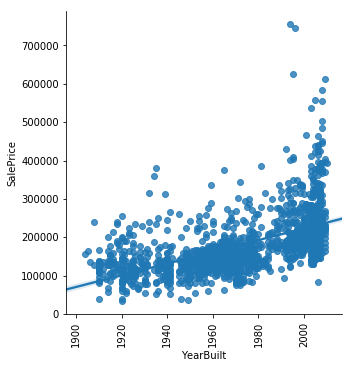

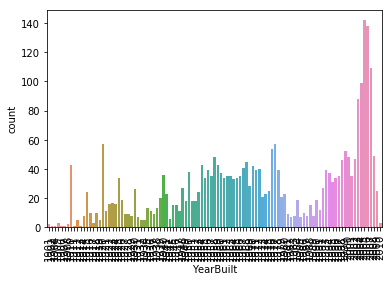

count   2919.0000
mean    1971.3128
std       30.2914
min     1872.0000
25%     1953.5000
50%     1973.0000
75%     2001.0000
max     2010.0000
Name: YearBuilt, dtype: float64


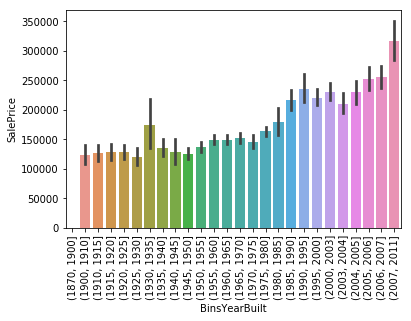

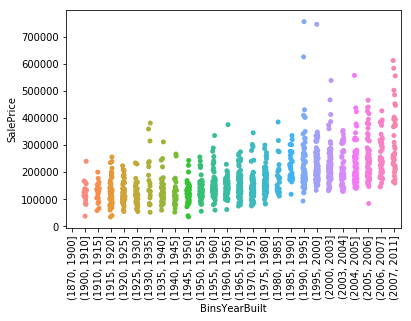

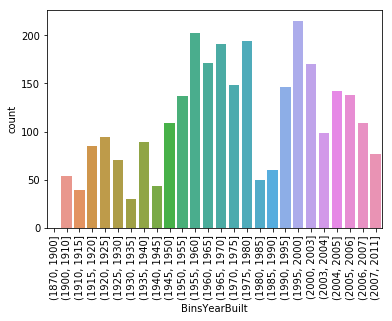

In [24]:
g=sns.lmplot(x="YearBuilt",y="SalePrice",data=df[df["YearBuilt"]>1900])
plt.xticks(rotation=90)
plt.show()
g=sns.countplot(x="YearBuilt",data=df[df["YearBuilt"]>1900])
plt.xticks(rotation=90)
plt.show()
print(df.describe()["YearBuilt"])
df["BinsYearBuilt"]=pd.cut(df["YearBuilt"],[1870,1900]+np.arange(1910,2001,5).tolist()+[2003,2004,2005,2006,2007,2011])
g=sns.barplot(x="BinsYearBuilt",y="SalePrice",data=df[df["YearBuilt"]>1900])
plt.xticks(rotation=90)
plt.show()
g=sns.stripplot(x="BinsYearBuilt",y="SalePrice",jitter=True,data=df[df["YearBuilt"]>1900])
plt.xticks(rotation=90)
plt.show()
g=sns.countplot(x="BinsYearBuilt",data=df[df["YearBuilt"]>1900])
plt.xticks(rotation=90)
plt.show()

### Feature engineering

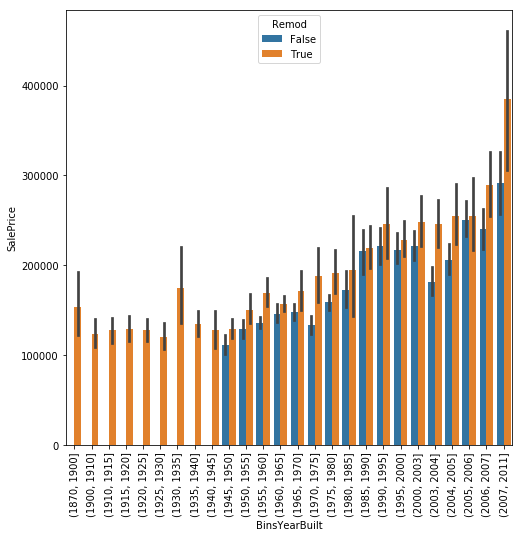

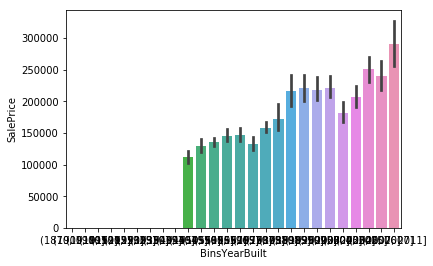

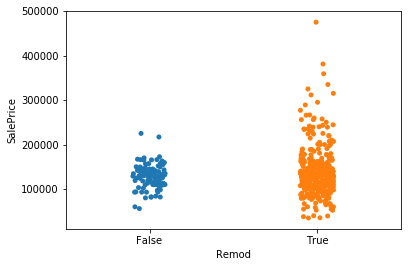

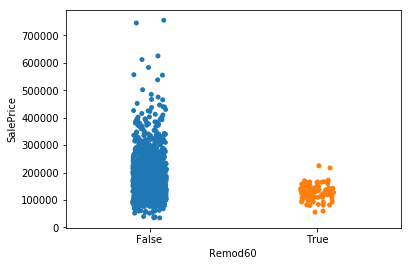

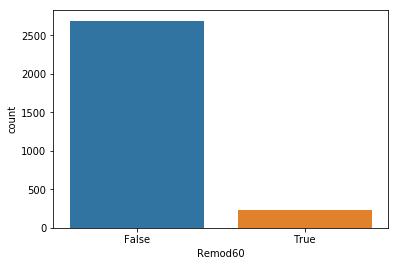

In [551]:
df["Remod"]=df["YearBuilt"]!=df["YearRemodAdd"]

plt.figure(figsize=(8,8))
g=sns.barplot(x="BinsYearBuilt",y="SalePrice",hue="Remod",data=df)
plt.xticks(rotation=90)
plt.show()

g=sns.barplot(x="BinsYearBuilt",y="SalePrice",data=df[df["Remod"]==False])
plt.show()

g=sns.stripplot(x="Remod",y="SalePrice",jitter=True,data=df[df["YearBuilt"]<1960])
plt.show()

df["Remod60"]=(~df["Remod"])&(df["YearBuilt"]<1960)
g=sns.stripplot(x="Remod60",y="SalePrice",jitter=True,data=df)
plt.show()
g=sns.countplot(x="Remod60",data=df)

### New stuff

### Preprocessing

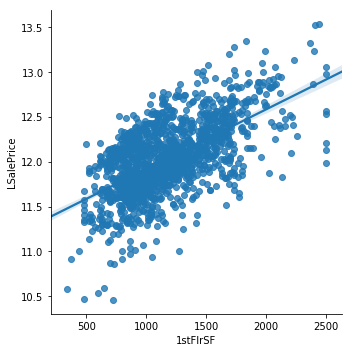

In [90]:
def clip(dataframe,feature,maximum):
    index=dataframe[dataframe[feature]>maximum].index.values
    dataframe.loc[index,feature]=maximum
    return dataframe    
df_pp=clip(df,"1stFlrSF",2500)
g=sns.lmplot(x="1stFlrSF",y="LSalePrice",data=df_pp)

### Model

In [75]:
df_dummies=pd.get_dummies(data=df_pp,columns=["YearBuilt","BinsYearBuilt","MSSubClass","Neighborhood","HouseStyle","HeatingQC",\
                                           "CentralAir","Electrical",
                                                 "SaleType","Functional","BldgType","YearRemodAdd","SaleCondition","Condition1",\
                                          "MSZoning"])
train_dummies=df_dummies[:1460]
test_dummies=df_dummies[1460:]
X=train_dummies.drop(columns="SalePrice")
y=train_dummies["SalePrice"].values
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=42)
print("X_train shape: %d x %d." % (X_train.shape[0],X_train.shape[1]))
print("X_test shape: %d x %d." % (X_test.shape[0],X_test.shape[1]))

X_train shape: 1095 x 374.
X_test shape: 365 x 374.


In [76]:
def root_mean_squared_error(truth,predictions):
    return np.sqrt(sum((truth-predictions) ** 2)/len(truth))
rmse_scorer=make_scorer(root_mean_squared_error,greater_is_better=False)

In [77]:
regr=[LinearRegression(),Lasso(alpha=0.001),Ridge(alpha=10),XGBRegressor(max_depth=5),RandomForestRegressor()]
features=[]

In [78]:
def cross_validation(regr=regr,X_train=X_train,y_train=np.log(y_train), features=features,scoring=rmse_scorer,cv=10,
                   table=True,preprocess=False):
    names=[]
    mean_test_scores=[]
    test_stds=[]
    mean_train_scores=[]
    train_stds=[]
    coef=[]
    outcomes={}
    
    
    for r in regr:
        name=r.__class__.__name__
        names.append(name)
        outcomes[name]=cross_validate(r,X_train[features],y_train,scoring=scoring,cv=cv)
        
        mean_test_scores.append(outcomes[name]["test_score"].mean())
        test_stds.append(outcomes[name]["test_score"].std())
        mean_train_scores.append(outcomes[name]["train_score"].mean())
        train_stds.append(outcomes[name]["train_score"].std())
        
        r.fit(X_train[features],y_train)
        
        #coef.append(r.coef_)
    
    
    regr_results=pd.DataFrame({"Regressor":names,"Mean train score":mean_train_scores,\
                               "Train std":train_stds,"Mean test score":mean_test_scores,\
                                "test_std":test_stds},index=np.arange(len(names)))
    if table:
        display(regr_results)
    
    #results=pd.DataFrame({"Features":features,"LinearRegression":coef[0],"Lasso":coef[1],\
    #                      "Ridge":coef[2]}).sort_values(by="Lasso",ascending=False)
    #sns.barplot(x="Features",y="Lasso",data=results[abs(results["Lasso"])>0.02])
    #plt.xticks(rotation=90)
    #plt.title("Strongest weights Lasso")
    return outcomes

In [87]:
def add_to_features(list_name_columns):
    outcome=[]
    col_names=X_train.columns.values.tolist()
    for n in list_name_columns:
        temp=[c for c in col_names if c[0:len(n)]==n]
        outcome+=temp
    return outcome
features=add_to_features(["1stFlrSF","MSSubClass","Neighborhood",
                          "CentralAir","Functional","YearRemodAdd","HeatingQC"
                          
                          
                          ])

In [88]:
outcomes=cross_validation(features=features)

,Regressor,Mean train score,Train std,Mean test score,test_std
0,LinearRegression,-0.1537,0.0022,-1197059.4784,2826945.1955
1,Lasso,-0.1655,0.0022,-0.1747,0.0227
2,Ridge,-0.1613,0.0023,-0.1726,0.0215
3,XGBRegressor,-0.1155,0.0019,-0.1742,0.0193
4,RandomForestRegressor,-0.0793,0.0024,-0.1860,0.0189


In [540]:
results.set_index("Features").filter(like="Remod60",axis=0)

,LinearRegression,Lasso,Ridge
Features,,,


### Test set

In [340]:
r=Ridge(alpha=10)
r.fit(X_train[features],np.log(y_train))
pred=r.predict(X_test[features])
root_mean_squared_error(np.log(y_test),pred)

0.16782953930113317

### Outcome

In [341]:
test_dummies.head()

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtFinType1,BsmtFinType2,BsmtFullBath,BsmtHalfBath,BsmtQual,BsmtUnfSF,Condition2,Electrical,EnclosedPorch,ExterCond,ExterQual,...,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM
1460,896,0,0,NaN,2,TA,No,468.0000,144.0000,Rec,LwQ,0.0000,0.0000,TA,270.0000,Norm,SBrkr,0,TA,TA,...,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
1461,1329,0,0,NaN,3,TA,No,923.0000,0.0000,ALQ,Unf,0.0000,0.0000,TA,406.0000,Norm,SBrkr,0,TA,TA,...,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
1462,928,701,0,NaN,3,TA,No,791.0000,0.0000,GLQ,Unf,0.0000,0.0000,Gd,137.0000,Norm,SBrkr,0,TA,TA,...,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
1463,926,678,0,NaN,3,TA,No,602.0000,0.0000,GLQ,Unf,0.0000,0.0000,TA,324.0000,Norm,SBrkr,0,TA,TA,...,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
1464,1280,0,0,NaN,2,TA,No,263.0000,0.0000,ALQ,Unf,0.0000,0.0000,Gd,1017.0000,Norm,SBrkr,0,TA,Gd,...,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0


In [342]:
test_x=test_dummies[features]

In [343]:
reg=Ridge(alpha=10)

In [344]:
reg.fit(X[features],np.log(y))

Ridge(alpha=10, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [345]:
pred_test=reg.predict(test_x[features])

In [346]:
final=np.e ** pred_test

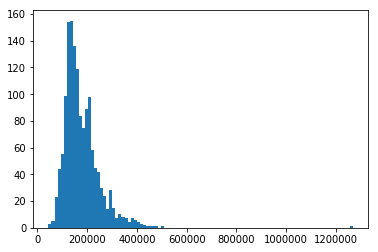

In [347]:
plt.hist(final,bins=100)
plt.show()

In [348]:
submission=pd.DataFrame({"Id":np.arange(1461,2920),"SalePrice":final})

In [349]:
submission.to_csv("SecondSubmissionAmes.csv",index=False)